# Jesse's ODE data

In [23]:
import torch
from torchdiffeq import odeint
import numpy as np

In [24]:
#governing_ODE_equations
def hyperbolic():
    #define your custom equation here
    mu = -0.05
    lam = -1.0

    number_of_states = 2

    def hyperbolic_rhs_torch(t,x):
        return torch.cat( (mu*x[:,0], lam*(x[:,1]-x[:,0]**2)), axis=-1)

    return hyperbolic_rhs_torch, number_of_states

def lorenz63():
    #define your custom equation here
    sigma = 10
    rho = 28
    beta = 8/3

    number_of_states = 3

    def lorenz63_rhs_torch(t,x):
        return torch.cat( (sigma*(x[:,1] - x[:,0]), rho*x[:,0]-x[:,0]*x[:,2]-x[:,1], x[:,0]*x[:,1] - beta*x[:,2]), axis=-1)

    return lorenz63_rhs_torch, number_of_states

def lorenz96():
    # system
    F = 8 
    N = 6

    number_of_states = 6
        
    def lorenz_rhs_torch(t,x):
        f = torch.zeros_like(x)
        for i in range(2,N-1):
            f[:,i]      = (x[:,i+1] - x[:,i-2]) * x[:,i-1] - x[:,i]   + F
            f[:,0]      = (x[:,1]   - x[:,N-2]) * x[:,N-1] - x[:,0]   + F
            f[:,1]      = (x[:,2]   - x[:,N-1]) * x[:,0]   - x[:,1]   + F
            f[:,N-1]    = (x[:,0]   - x[:,N-3]) * x[:,N-2] - x[:,N-1] + F
        return f 
    
    return lorenz_rhs_torch, number_of_states

In [25]:
def generate_dataset(data_func=lorenz96,
                    dt = 0.01, 
                    total_steps = 1024 * 5, 
                    interval = (-1.0,1.0),
                    trainset_size = 80, 
                    valset_size=16, 
                    testset_size = 16,
                    save=False):
    
    np.random.seed(2)

    #get device
    device = torch.device('cpu')
    #get right hand side of the governing equations for ODE
    #get number of states
    rhs_equation,num_states = data_func()
    #set up time coordinates
    t = torch.linspace(0, (total_steps)*dt, total_steps+1).to(device)

    #generate three splits of the trajectory dataset
    dataset = {}
    for i,tag in enumerate(['train','val','test']):
        #each split has the dimension of (split_size * t * num_states) 
        split_name = tag+'set'
        split_size = eval(split_name+'_size')
        dataset[split_name] = np.zeros((split_size, total_steps+1, num_states))

        #generate trajectories for random initial conditions
        for j in range(split_size):
            x_init = torch.tensor(
                        np.random.uniform(
                            interval[0], 
                            interval[1], 
                            num_states)
                                ).to(device).unsqueeze(0)

            sol = odeint(
                        rhs_equation, 
                        x_init, 
                        t, 
                        method='dopri5').to(device).squeeze().detach().numpy()

            dataset[split_name][j, :, :] = sol
            
    
    #check the range for every state in the training set
    domain_range = []
    temp_data = dataset['trainset'].reshape([-1,num_states])
    for i in range(num_states):
        domain_range.append(np.array([np.min(temp_data[:,i]), np.max(temp_data[:,i])]))
    domain_range = np.row_stack(domain_range)

    if save:
        np.savez(f'./data/{data_func.__name__}_torch_{str(interval[0])}_{str(interval[1])}.npz', 
            train_data = dataset['trainset'],
            val_data = dataset['valset'],
            test_data = dataset['testset'], 
            range = domain_range,
            num_states=num_states,
            time_steps = t.detach().numpy(),
            data_name = data_func.__name__)

    return dataset

In [26]:
d = generate_dataset(data_func=hyperbolic,
              dt = 1e-2, #lorenz
              total_steps = 1024 * 5, 
              interval = (-1,1),
              trainset_size = 80, 
              valset_size=16, 
              testset_size = 16,
              save=False)
d

{'trainset': array([[[-1.28010196e-01, -9.48147536e-01],
         [-1.27946207e-01, -9.38550343e-01],
         [-1.27882250e-01, -9.29048806e-01],
         ...,
         [-9.90569555e-03,  1.09025661e-04],
         [-9.90074288e-03,  1.08916698e-04],
         [-9.89579458e-03,  1.08807884e-04]],
 
        [[ 9.93249558e-02, -1.29355215e-01],
         [ 9.92753057e-02, -1.27969995e-01],
         [ 9.92256804e-02, -1.26598657e-01],
         ...,
         [ 7.68597194e-03,  6.56377704e-05],
         [ 7.68212909e-03,  6.55721326e-05],
         [ 7.67828963e-03,  6.55065864e-05]],
 
        [[-1.59264396e-01, -3.39330358e-01],
         [-1.59184784e-01, -3.35701704e-01],
         [-1.59105211e-01, -3.32109407e-01],
         ...,
         [-1.23242106e-02,  1.68763130e-04],
         [-1.23180488e-02,  1.68594401e-04],
         [-1.23118923e-02,  1.68425903e-04]],
 
        ...,
 
        [[-8.95554545e-01, -8.68672668e-01],
         [-8.95106880e-01, -8.52053014e-01],
         [-8.94659438e

# Ben's Chaotic Data

## Set dataset parameters

Note that the sizes of trainset, valset, and testset refer to number of time steps rather than number of examples. So, while the ODE dataset varies the number of examples based on the split and maintains the number of timesteps, the chaotic dataset varies the number of timesteps based on the split and maintains the number of examples. This is to remain consistent with procedure outlined in https://arxiv.org/pdf/2409.15771. The specific values set here are also derived from the same procedure.

In [32]:
trajectories_per_system=80
trainset_size=435
valset_size=77
testset_size=300
n = trainset_size + valset_size + testset_size
num_states = 4

## Filter systems based on metadata

In [34]:
import requests
import simplejson as json
import urllib.request, json 

metadata_url = "https://raw.githubusercontent.com/williamgilpin/dysts/refs/heads/master/dysts/data/chaotic_attractors.json"

with urllib.request.urlopen(metadata_url) as url:
    data = json.load(url)

# we want autonomous systems and embedding dimension of 4
target_systems = [key for key, value in data.items() 
                             if value.get('nonautonomous') == False and value.get('embedding_dimension') == num_states]

# output as yaml list to easily paste into sweep config
for target_system in target_systems:
    print(f"- ./data/dysts_{target_system}.npz")

- ./data/dysts_DoublePendulum.npz
- ./data/dysts_HenonHeiles.npz
- ./data/dysts_HyperBao.npz
- ./data/dysts_HyperCai.npz
- ./data/dysts_HyperJha.npz
- ./data/dysts_HyperLorenz.npz
- ./data/dysts_HyperLu.npz
- ./data/dysts_HyperPang.npz
- ./data/dysts_HyperQi.npz
- ./data/dysts_HyperRossler.npz
- ./data/dysts_HyperWang.npz
- ./data/dysts_HyperXu.npz
- ./data/dysts_HyperYan.npz
- ./data/dysts_HyperYangChen.npz
- ./data/dysts_Lorenz96.npz
- ./data/dysts_LorenzStenflo.npz
- ./data/dysts_NuclearQuadrupole.npz
- ./data/dysts_Qi.npz
- ./data/dysts_SwingingAtwood.npz


## Generate dataset of autonomous systems

In [35]:
from dysts.systems import make_trajectory_ensemble
from dysts.sampling import GaussianInitialConditionSampler
import numpy as np
import warnings
from tqdm import trange

ensembles = []
for t in trange(trajectories_per_system):
    # suppress warnings about initial conditions (kind of dangerous, be sure to comment out if you're running into any issues)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # create sampler with different seed for different initial conditions
        transform = GaussianInitialConditionSampler(random_seed=t)

        # returns dict with system names as keys and values with data (times, states) because we set return_times=True
        ensemble = make_trajectory_ensemble(n, return_times=True, timescale="Lyapunov", pts_per_period=30, resample=True, subset=target_systems, ic_transform=transform, use_multiprocessing=True)  

        # print the last point of the first target system to ensure they're different
        print(ensemble[target_systems[0]][1][-1])

        ensembles.append(ensemble)

  1%|▏         | 1/80 [00:54<1:11:34, 54.36s/it]

[-0.70631448 -0.89522536 -7.78709797 -1.5646774 ]


  2%|▎         | 2/80 [01:50<1:11:54, 55.31s/it]

[ 0.05811695 -0.7048358   3.11340292  1.32117965]


  4%|▍         | 3/80 [02:44<1:10:21, 54.82s/it]

[0.47185796 0.38499964 9.31038362 2.39431135]


  5%|▌         | 4/80 [03:54<1:16:51, 60.67s/it]

[ 0.22738464 -0.01362329 -2.46964468 -0.64302695]


  6%|▋         | 5/80 [05:07<1:21:43, 65.37s/it]

[-0.98409615 -0.32448386 -7.69616052  0.17563592]


  8%|▊         | 6/80 [06:19<1:23:10, 67.43s/it]

[-0.66845397 -0.21942101 -0.19452212 -2.63893826]


  9%|▉         | 7/80 [07:31<1:24:04, 69.10s/it]

[0.88995694 0.55009392 2.72098151 1.08198866]


 10%|█         | 8/80 [08:42<1:23:35, 69.66s/it]

[-0.04410523 -0.95135104 -4.56637604  3.01738061]


 11%|█▏        | 9/80 [09:53<1:22:48, 69.98s/it]

[-0.36103845 -0.3931232  -1.52468963 -1.70769208]


 12%|█▎        | 10/80 [11:00<1:20:37, 69.10s/it]

[ 0.55774938 -0.56345189 -4.09454905  2.56427019]


 14%|█▍        | 11/80 [12:11<1:19:59, 69.55s/it]

[-0.19654231 -0.4472549   3.99059587  0.29899871]


 15%|█▌        | 12/80 [13:20<1:18:36, 69.35s/it]

[ 0.10615558 -0.83423566 -0.94068648 -1.00016201]


 16%|█▋        | 13/80 [14:31<1:18:08, 69.98s/it]

[-0.0892458   0.91295613 -1.82137372  0.2827146 ]


 18%|█▊        | 14/80 [15:46<1:18:37, 71.47s/it]

[ 0.97663944  0.87125664 -4.26887545 -2.97733157]


 19%|█▉        | 15/80 [17:01<1:18:41, 72.64s/it]

[-0.21307976  0.20604422 -9.80235718 -4.26204785]


 20%|██        | 16/80 [18:20<1:19:25, 74.47s/it]

[ 0.87104821 -0.83742107 -6.4721121   3.46097584]


 21%|██▏       | 17/80 [19:37<1:18:54, 75.16s/it]

[ 0.90028114 -0.99580207 -6.27587439  2.24127543]


 22%|██▎       | 18/80 [20:52<1:17:41, 75.18s/it]

[ 0.41349668 -0.78181542 -5.53112551  2.76209557]


 24%|██▍       | 19/80 [22:14<1:18:41, 77.40s/it]

[-0.83992504  0.99998903  1.69038673 -1.00594239]


 25%|██▌       | 20/80 [23:31<1:17:09, 77.17s/it]

[-0.97858945  0.97917134  3.17837238 -1.16004645]


 26%|██▋       | 21/80 [24:50<1:16:16, 77.57s/it]

[-0.1105786   0.97881111  3.89749028  2.72017616]


 28%|██▊       | 22/80 [26:09<1:15:34, 78.18s/it]

[-0.51902357 -0.67904018 -4.47580552 -1.10729617]


 29%|██▉       | 23/80 [27:30<1:15:05, 79.04s/it]

[-0.94482991 -0.84192633  2.25381476  2.06555767]


 30%|███       | 24/80 [28:45<1:12:26, 77.62s/it]

[-0.99941145 -0.97848339 -3.93254102 -2.10767196]


 31%|███▏      | 25/80 [30:03<1:11:22, 77.86s/it]

[ 0.31810744 -0.93711178  6.68551107 -2.78207977]


 32%|███▎      | 26/80 [31:17<1:09:06, 76.78s/it]

[0.70742253 0.43549933 8.08039078 4.58618238]


 34%|███▍      | 27/80 [32:32<1:07:23, 76.30s/it]

[ 0.30354515  0.4442124  -7.40722233 -4.93920985]


 35%|███▌      | 28/80 [33:49<1:06:18, 76.52s/it]

[-0.54659041  0.27542915 -8.03184322  0.48513362]


 36%|███▋      | 29/80 [35:05<1:04:50, 76.28s/it]

[-0.75735158 -0.98985497 -0.51388178  0.81438855]


 38%|███▊      | 30/80 [36:11<1:01:01, 73.24s/it]

[ 0.14651264  0.9726166   7.50593932 -0.96174152]


 39%|███▉      | 31/80 [37:05<55:04, 67.44s/it]  

[-0.33312011 -0.09280722  3.975804   -0.30138784]


 40%|████      | 32/80 [38:00<50:53, 63.62s/it]

[ 0.53029373  0.04531418  4.85164999 -0.39153258]


 41%|████▏     | 33/80 [38:55<47:44, 60.94s/it]

[-0.74648102  0.18807247  2.71528873 -3.03735265]


 42%|████▎     | 34/80 [39:48<44:55, 58.61s/it]

[0.8734103  0.64144896 3.26996285 1.28817   ]


 44%|████▍     | 35/80 [40:42<42:59, 57.31s/it]

[-0.06059474 -0.6161857  -5.47672448  0.60592422]


 45%|████▌     | 36/80 [41:37<41:31, 56.63s/it]

[ 0.99227079 -0.96592919  0.48412863  1.34813558]


 46%|████▋     | 37/80 [42:30<39:41, 55.39s/it]

[-0.15281249 -0.95154814  7.24134211 -0.54042517]


 48%|████▊     | 38/80 [43:22<38:13, 54.60s/it]

[ 0.63602339 -0.7092981  -2.46558568 -4.48339146]


 49%|████▉     | 39/80 [44:16<37:08, 54.34s/it]

[0.71569072 0.92208827 2.04797136 1.67746844]


 50%|█████     | 40/80 [45:11<36:18, 54.47s/it]

[ 0.8209866  -0.68955269 -3.04366809  2.21940699]


 51%|█████▏    | 41/80 [46:04<35:03, 53.93s/it]

[-0.99039562  0.9989804   4.19786265 -2.70981261]


 52%|█████▎    | 42/80 [46:58<34:11, 53.99s/it]

[-0.66602744 -0.97978033 -0.70701247  0.74237482]


 54%|█████▍    | 43/80 [47:52<33:17, 54.00s/it]

[-0.02325276 -0.72372942 -7.26425581  0.73719137]


 55%|█████▌    | 44/80 [48:46<32:30, 54.17s/it]

[-0.72006895 -0.24450624 -9.57287133 -3.14037097]


 56%|█████▋    | 45/80 [49:39<31:24, 53.85s/it]

[-0.99814497  0.99718554 -1.36231528 -1.15058514]


 57%|█████▊    | 46/80 [50:34<30:34, 53.95s/it]

[ 0.5461521  -0.56665466 -4.3811033   0.89590001]


 59%|█████▉    | 47/80 [51:28<29:48, 54.21s/it]

[-0.01669849 -0.53259627 -1.78682031  2.13054672]


 60%|██████    | 48/80 [52:23<28:58, 54.33s/it]

[ 0.33070234  0.92143752 -6.83252902  0.96519297]


 61%|██████▏   | 49/80 [53:17<27:59, 54.19s/it]

[ 0.88789956 -0.44166323  1.88845554 -1.47679933]


 62%|██████▎   | 50/80 [54:10<26:57, 53.93s/it]

[-0.89071658  0.81952684 -7.51774777  2.79629686]


 64%|██████▍   | 51/80 [55:04<26:02, 53.88s/it]

[ 0.986041   -0.88684637 -5.91237196  3.39785852]


 65%|██████▌   | 52/80 [55:56<24:51, 53.26s/it]

[-0.14833688 -0.96928714 -7.1630752   1.24197037]


 66%|██████▋   | 53/80 [56:49<23:57, 53.24s/it]

[-0.15728398 -0.70754428  1.97547026 -1.87791609]


 68%|██████▊   | 54/80 [57:40<22:50, 52.73s/it]

[-0.24785564  0.7429967   5.77770234  4.53093918]


 69%|██████▉   | 55/80 [58:34<22:02, 52.92s/it]

[-0.63084293 -0.74288504 -5.28017319 -0.61610374]


 70%|███████   | 56/80 [59:28<21:15, 53.14s/it]

[-0.77823586  0.94778758  5.28866599 -2.98338039]


 71%|███████▏  | 57/80 [1:00:21<20:27, 53.38s/it]

[-0.95422916  0.14414526 -0.48229669  3.5144726 ]


 72%|███████▎  | 58/80 [1:01:14<19:30, 53.23s/it]

[-0.69883464 -0.99448874  4.97651616 -1.05359381]


 74%|███████▍  | 59/80 [1:02:08<18:40, 53.36s/it]

[ 0.30037103 -0.98194956 -3.38647197 -2.53206257]


 75%|███████▌  | 60/80 [1:03:01<17:43, 53.17s/it]

[ 0.98537114 -0.18902348  0.324582   -3.73748386]


 76%|███████▋  | 61/80 [1:03:55<16:57, 53.57s/it]

[ 0.9643515  -0.97904882  1.92183741 -1.23004508]


 78%|███████▊  | 62/80 [1:04:48<15:59, 53.33s/it]

[ 0.99873925  0.20978652 -0.32704188 -3.90566721]


 79%|███████▉  | 63/80 [1:05:41<15:07, 53.35s/it]

[0.83924707 0.98349884 3.36447522 0.97196132]


 80%|████████  | 64/80 [1:06:34<14:10, 53.14s/it]

[ 0.97604909 -0.9506548   0.71899923  0.54050454]


 81%|████████▏ | 65/80 [1:07:27<13:16, 53.12s/it]

[0.64226519 0.97241652 1.35583817 0.99470317]


 82%|████████▎ | 66/80 [1:08:21<12:26, 53.31s/it]

[ 0.89710437 -0.51892733  1.45885622  4.24448296]


 84%|████████▍ | 67/80 [1:09:15<11:34, 53.41s/it]

[-0.24681319  0.32811129 -4.54981375  0.98712823]


 85%|████████▌ | 68/80 [1:10:08<10:40, 53.39s/it]

[-0.75332501 -0.45240835  4.98794276 -2.02167406]


 86%|████████▋ | 69/80 [1:11:01<09:47, 53.39s/it]

[-0.80670793  0.62358702 -2.95501107  2.14138257]


 88%|████████▊ | 70/80 [1:11:53<08:49, 52.91s/it]

[ 0.98071691 -0.14100201  7.31223584 -1.89107009]


 89%|████████▉ | 71/80 [1:12:46<07:56, 52.94s/it]

[-0.94679335 -0.9995302   0.64355316  1.39270402]


 90%|█████████ | 72/80 [1:13:41<07:07, 53.40s/it]

[ 0.862855    0.11689279 -1.85693268  0.96546269]


 91%|█████████▏| 73/80 [1:14:34<06:13, 53.32s/it]

[-0.2370333  -0.26940108  3.87043128  0.00440726]


 92%|█████████▎| 74/80 [1:15:27<05:20, 53.37s/it]

[-0.22013962 -0.2028336   2.71271445  0.66954083]


 94%|█████████▍| 75/80 [1:16:21<04:27, 53.51s/it]

[ 0.99777108  0.28575698 -7.74615922 -0.94696176]


 95%|█████████▌| 76/80 [1:17:14<03:33, 53.29s/it]

[ 0.02418322 -0.8048786  -3.1274721   0.62382523]


 96%|█████████▋| 77/80 [1:18:07<02:40, 53.35s/it]

[ 0.99507997  0.97018724 -1.81441573  1.24829243]


 98%|█████████▊| 78/80 [1:19:01<01:46, 53.36s/it]

[0.0306382  0.95667499 3.48328098 2.85286692]


 99%|█████████▉| 79/80 [1:19:54<00:53, 53.40s/it]

[-0.7096887   0.74695622  4.49927189 -1.11043046]


100%|██████████| 80/80 [1:20:47<00:00, 60.59s/it]

[ 0.93855803 -0.95855043  0.66918391 -0.61152917]


saving the computed ensembles in case the notebook state is lost

In [36]:
import pickle
import numpy as np
import sys

# for easy loading
with open("./data/ensembles.pkl", "wb") as f:
    pickle.dump(ensembles, f)

# for human readability
with open("./data/ensembles.dat", "w") as f:
    np.set_printoptions(threshold=sys.maxsize)
    print(ensembles, file=f)

loading the computed ensembles in case the notebook state is lost

In [2]:
import pickle

with open("./data/ensembles.pkl", "rb") as f:
    ensembles = pickle.load(f)

## Wrangle dataset into correct format

In [47]:
import numpy as np
import torch
import sys

for target_system in target_systems:
    dataset = {"trainset": [], "valset": [], "testset": []}

    # get timesteps from first trajectory of target system
    first_ensemble = ensembles[0]
    first_trajectory = first_ensemble[target_system]
    time_steps = first_trajectory[0]

    # make the split
    target_trajectories = [ensemble[target_system] for ensemble in ensembles]
    for trajectory in target_trajectories:
        states = trajectory[1]
        dataset["trainset"].append(states[:trainset_size])
        dataset["valset"].append(states[trainset_size:trainset_size+valset_size])
        dataset["testset"].append(states[trainset_size+valset_size:])

    # Convert lists of arrays to np arrays
    dataset["trainset"] = np.array(dataset["trainset"])
    dataset["valset"] = np.array(dataset["valset"])
    dataset["testset"] = np.array(dataset["testset"])

    # check the range for every state in the training set
    domain_range = []
    temp_data = dataset["trainset"].reshape([-1, num_states])
    for i in range(num_states):
        domain_range.append(
            np.array([np.min(temp_data[:, i]), np.max(temp_data[:, i])])
        )
    domain_range = np.row_stack(domain_range)

    # save the dataset
    data_func_name = f"dysts_{target_system}"
    np.savez(
        f"./data/{data_func_name}.npz",
        train_data=dataset["trainset"],
        val_data=dataset["valset"],
        test_data=dataset["testset"],
        range=domain_range,
        num_states=num_states,
        train_time_steps=time_steps[:trainset_size],
        val_time_steps=time_steps[trainset_size:trainset_size+valset_size],
        test_time_steps=time_steps[trainset_size+valset_size:],
        time_steps=time_steps,  # this shouldn't be used in the train script
        data_name=data_func_name,
    )

/tmp/ipykernel_24727/1604947555.py:33: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  domain_range = np.row_stack(domain_range)


Sanity check the shape of one of the saved datasets

In [48]:
import numpy as np
import torch

data = np.load("./data/dysts_DoublePendulum.npz")
train_data = torch.tensor(data["train_data"][:, :, :])
print(train_data.shape)

torch.Size([80, 435, 4])


# Archive

## Compute trajectory

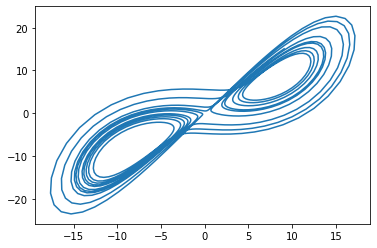

In [ ]:
from dysts.flows import Lorenz
from matplotlib import pyplot as plt

model = Lorenz()
sol = model.make_trajectory(1000)
plt.plot(sol[:, 0], sol[:, 1])

## Explore pre-computed multivariate data

,id,time,values_0,values_1,values_2,values_3,values_4,values_5,values_6,values_7,values_8,values_9
Aizawa,0.0,0.000000,-0.791445,-2.195360,0.564000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aizawa,0.0,0.025859,-0.592175,-2.274252,0.520937,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aizawa,0.0,0.051717,-0.384373,-2.333496,0.477200,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aizawa,0.0,0.077576,-0.170204,-2.372270,0.432803,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aizawa,0.0,0.103434,0.048135,-2.389950,0.387774,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
ZhouChen,132.0,8.715304,1.218368,-0.302109,0.177545,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZhouChen,132.0,8.724063,1.253220,-0.288478,0.156669,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZhouChen,132.0,8.732822,1.288620,-0.273386,0.133433,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZhouChen,132.0,8.741581,1.324473,-0.256663,0.107522,0.0,0.0,0.0,0.0,0.0,0.0,0.0


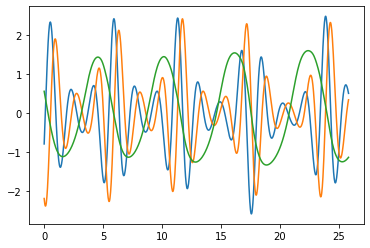

In [ ]:
from matplotlib import pyplot as plt

d = load_dataset(subsets="train", data_format="pandas", standardize=True, univariate=False)
display(d)

t = d[d["id"] == 0]
plt.plot(t["time"], t["values_0"])
plt.plot(t["time"], t["values_1"])
plt.plot(t["time"], t["values_2"])


## Wrangle precomputed dataset into correct format

In [59]:
from dysts_data.datasets import load_dataset, TimeSeriesDataset
import numpy as np
import torch
import sys

def generate_dataset_chaotic(
    trainset_size=80, valset_size=16, testset_size=16, save=False
):
    num_states = 4  # time and 3D coordinates
    dataset = {}

    for i, (tag, subset) in enumerate(
        zip(["train", "val", "test"], ["train", "train_val", "test_all"])
    ):
        # load appropriate subset of dataset (more info here: https://www.wgilpin.com/dysts/spbuild/html/index.html)
        precomputed_dataset = load_dataset(
            subsets=subset, data_format="pandas", standardize=True, univariate=False
        )
        # filter to keep only autonomous systems
        precomputed_dataset = precomputed_dataset[precomputed_dataset.index.isin(autonomous_systems)]

        # Get the first trajectory to determine dt and steps
        first_traj = precomputed_dataset[precomputed_dataset["id"] == 0]
        times = first_traj["time"].values
        dt = times[1] - times[0]  # Get dt from first trajectory
        total_steps = len(first_traj)
        
        # Print info for verification
        print(f"Dataset {subset} info:")
        print(f"{dt = }")
        print(f"{total_steps = }\n")

        # each split has the dimension of (split_size * total_steps * num_states)
        split_name = tag + "set"
        split_size = eval(split_name + "_size")
        dataset[split_name] = np.zeros((split_size, total_steps, num_states))

        # fill in trajectories
        available_ids = sorted(precomputed_dataset["id"].unique())
        for j in range(split_size):
            # select trajectory sequentially
            trajectory = precomputed_dataset[precomputed_dataset["id"] == available_ids[j]]

            # wrangle into correct datatype & shape, and then put it in the dataset
            list_of_lists = trajectory[["time", "values_0", "values_1", "values_2"]].values.tolist()
            dataset[split_name][j, :, :] = list_of_lists

    # check the range for every state in the training set
    domain_range = []
    temp_data = dataset["trainset"].reshape([-1, num_states])
    for i in range(num_states):
        domain_range.append(
            np.array([np.min(temp_data[:, i]), np.max(temp_data[:, i])])
        )
    domain_range = np.row_stack(domain_range)

    if save:
        data_func_name = "chaotic-systems"
        np.savez(
            f"./data/{data_func_name}_torch.npz",
            train_data=dataset["trainset"],
            val_data=dataset["valset"],
            test_data=dataset["testset"],
            range=domain_range,
            num_states=num_states,
            time_steps=np.arange(0, total_steps, dt),
            data_name=data_func_name,
        )

    return dataset


# np.set_printoptions(threshold=sys.maxsize)
generate_dataset_chaotic(save=True)

NameError: name 'autonomous_systems' is not defined